In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf

import gpflow.multikernels as mk
import gpflow.multifeatures as mf

from gpflow.conditionals import conditional

In [2]:
X = np.random.rand(100)[:, None] * 10 - 5
G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))
Ptrue = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])
Y = np.matmul(G, Ptrue)
Y += np.random.randn(*Y.shape) * [0.2, 0.2, 0.2]

D = 1
M = 20
L = 2
P = 3
MAXITER = 200

In [3]:
pX = np.linspace(-6, 6, 100)[:, None]
def plot_model(m):
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(m.X.value, m.Y.value, 'x')
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)

## Shared Independent MOK & Shared Independent Features (SLOW CODE)

We will use the same kernel to model each of the output dimensions.
We will use the same inducing inputs in each of the approximations.

In [4]:
q_mu = np.zeros((M, P)).reshape(M * P, 1)
q_sqrt = np.eye(M * P).reshape(1, M * P, M * P)

with gpf.defer_build():
    kernel = mk.SharedIndependentMok(gpf.kernels.RBF(1) + gpf.kernels.Linear(1), P)
    feature = gpf.features.InducingPoints(X[:M,...].copy())

In [5]:
with gpf.defer_build():
    m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feature)
    m.q_mu = gpf.Param(q_mu, dtype=gpf.settings.float_type)
    m.q_sqrt = gpf.Param(q_sqrt, dtype=gpf.settings.float_type, transform=gpf.transforms.LowerTriangular(M * P, 1))

m.compile()

Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok


In [6]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 49.642996
  Number of iterations: 201
  Number of functions evaluations: 214


Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok


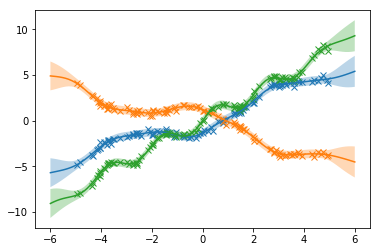

In [7]:
plot_model(m)

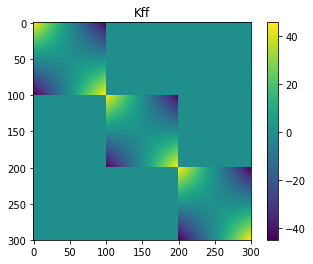

In [9]:
K = (kernel.compute_K_symm(pX))
K_trans = np.transpose(K, [1, 0, 3, 2])
plt.imshow(np.reshape(K_trans, [100 * 3, 100*3]));
plt.colorbar();
plt.title("Kff");

All the outputs are uncorrelated, and the same kernel is used for each output. However, during the `conditional` calculations we do not assume this particular block-diagonal structure. 

## Shared Independent MOK & Shared Independent Features

We will use the same kernel to model each of the output dimensions.
We will use the same inducing inputs in each of the approximations.

In [10]:
kernel = mk.SharedIndependentMok(gpf.kernels.RBF(1) + gpf.kernels.Linear(1), P)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [11]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

Kuu: SharedIndependentMof - SharedIndependentMok
Kuf: SharedIndependentMof - SharedIndependentMok


In [12]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 46.190876
  Number of iterations: 201
  Number of functions evaluations: 225


Kuu: SharedIndependentMof - SharedIndependentMok
Kuf: SharedIndependentMof - SharedIndependentMok


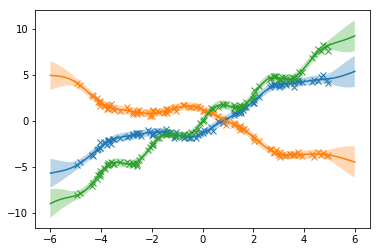

In [13]:
plot_model(m)

Again, same kernel used for each output dimension and the outputs are uncorrelated. In the `conditional`, however, we explicitly use the block-diagonal structure.

## Separate Independent MOK & Shared Independent Features (SLOW CODE)

In [14]:
q_mu = np.zeros((M, P)).reshape(M * P, 1)
q_sqrt = np.eye(M * P).reshape(1, M * P, M * P)

with gpf.defer_build():
    kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
    kernel = mk.SeparateIndependentMok(kern_list)
    feature = gpf.features.InducingPoints(X[:M,...].copy())

In [15]:
with gpf.defer_build():
    m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feature)
    m.q_mu = gpf.Param(q_mu, dtype=gpf.settings.float_type)
    m.q_sqrt = gpf.Param(q_sqrt, dtype=gpf.settings.float_type, transform=gpf.transforms.LowerTriangular(M * P, 1))

m.compile()

Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok


In [16]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 185.794509
  Number of iterations: 201
  Number of functions evaluations: 225


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 185.794509
  Number of iterations: 201
  Number of functions evaluations: 225


Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok


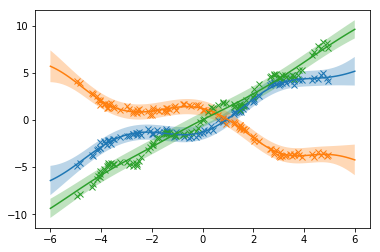

In [17]:
plot_model(m)

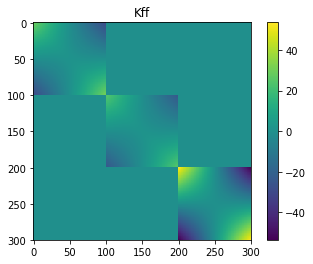

In [18]:
K = (kernel.compute_K_symm(pX))
K_trans = np.transpose(K, [1, 0, 3, 2])
plt.imshow(np.reshape(K_trans, [100 * 3, 100*3]));
plt.colorbar();
plt.title("Kff");

All the outputs are uncorrelated, *but a different kernel* is used for each output. However, during the `conditional` calculations we do not assume this particular block-diagonal structure. 

## Separate Independent MOK & Shared Independent Features

In [19]:
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
kernel = mk.SeparateIndependentMok(kern_list)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [20]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object


In [21]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 185.637556
  Number of iterations: 201
  Number of functions evaluations: 219


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 185.637556
  Number of iterations: 201
  Number of functions evaluations: 219


Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object


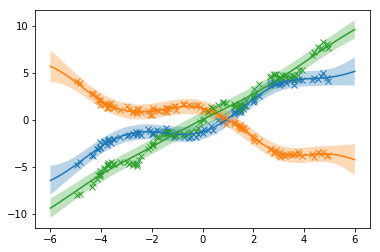

In [22]:
plot_model(m)

In [23]:
m.compute_log_likelihood()

-185.63755603244775

## Separate Independent Kernel & Separate Independent Features

In [4]:
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
kernel = mk.SeparateIndependentMok(kern_list)
feature_list = [gpf.features.InducingPoints(X[np.random.permutation(len(X))[:M],...].copy()) for _ in range(P)]
feature = mf.SeparateIndependentMof(feature_list)

In [5]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object


In [6]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 86.657678
  Number of iterations: 201
  Number of functions evaluations: 221


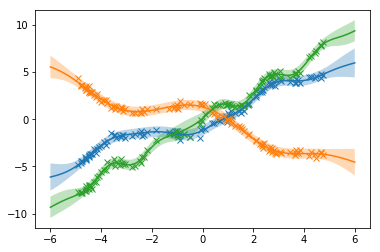

In [8]:
plot_model(m)

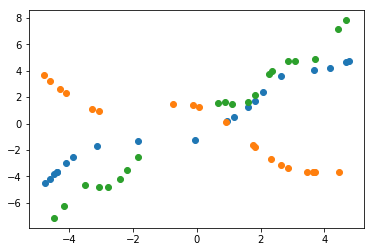

In [23]:
for i in range(len(m.feature.feat_list)):
    q_mu_unwhitenede, q_var_unwhitened = m.predict_f(m.feature.feat_list[i].Z.value)
    plt.plot(m.feature.feat_list[i].Z.value, q_mu_unwhitenede[:, [i]], "o")

This plot shows that we use different inducing *inputs* in each output dimension.

## Mixed

In [30]:
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(L)]
kernel = mk.SeparateMixedMok(kern_list, W=Ptrue)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [31]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

Kuu: SharedIndependentMof, (SeparateIndependentMok, SeparateMixedMok)


ValueError: not enough values to unpack (expected 4, got 3)